# Assignment

In this assignment, we want to reinforce the concepts we covered in the lecture. Let's first load the required libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize': (10, 8)})
import matplotlib.pyplot as plt

import scipy
import scipy.stats as ss
from scipy.stats import ttest_rel
import numpy.random as nr
import statsmodels
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.stats.power as sp
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

We will be using the automobile price data for this assignment.

In [2]:
def read_auto_data(fileName="auto-price.csv"):
    'Function to load the auto price data set from a .csv file' 

    ## Read the .csv file with the pandas read_csv method
    auto_price = pd.read_csv(fileName)
    
    ## Remove rows with missing values, accounting for missing values coded as '?'
    cols = ['price', 'bore', 'stroke', 'horsepower', 'peak-rpm']
    for column in cols:
        auto_price.loc[auto_price[column] == '?', column] = np.nan
    auto_price.dropna(axis = 0, inplace = True)
    auto_price.drop(columns = 'normalized-losses', inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_price[column] = pd.to_numeric(auto_price[column])
        
    return auto_price


auto_price = read_auto_data()
auto_price.head()

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
auto_price.rename(columns={'body-style':'bodystyle',
                          'fuel-type':'fueltype',
                           'drive-wheels':'drivewheels'}, inplace=True)

Run the following tests on the data:

1. Test whether price and log price (using `np.log10`) follow a normal distribution. Use both a **graphical** method and a **formal** test. For the rest of this exercise, choose between using price or log price based on which of the two best fits a normal distribution. <span style="color:red" float:right>[5 point]</span>

Scratch and Resources

- https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/how-to-decide-if-a-hypothesis-test-is-a-left-tailed-test-or-a-right-tailed-test/

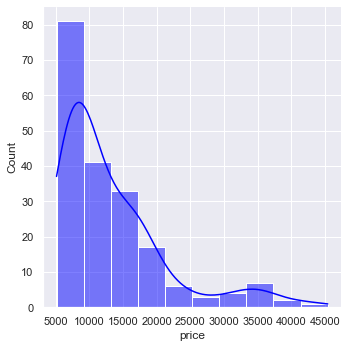

In [4]:
#Using a displot to visualize the distribution of the price

sns.displot(data=auto_price, x='price', bins=10, kde=True, color='blue');

In [5]:
#Just to make sure I understand the distribution - also looking at the values
auto_price['price'].describe()

count      195.000000
mean     13248.015385
std       8056.330093
min       5118.000000
25%       7756.500000
50%      10245.000000
75%      16509.000000
max      45400.000000
Name: price, dtype: float64

Shapiro Wilk Test for normal distribution
- https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

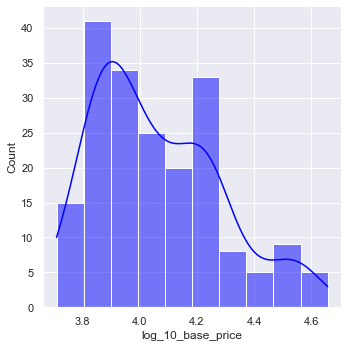

In [6]:
#Creating the log10 base price for comparison with the price
auto_price['log_10_base_price']=np.log10(auto_price['price'])
#Using displot to graphically visualize the data - shows more of a normal distribution 
sns.displot(data=auto_price, x='log_10_base_price', bins=10, kde=True, color='blue');

In [7]:
auto_price['log_10_base_price'].describe()

count    195.000000
mean       4.060490
std        0.221043
min        3.709100
25%        3.889665
50%        4.010512
75%        4.217721
max        4.657056
Name: log_10_base_price, dtype: float64

To the naked eye it seems that the distribution is skewed for the price with a slightly less skewed distribution for the log10 price. Can test to see if there is a significant difference using a T-Test (both continuous variables)

- Hypothesis: There is no statistical difference between the price and log price 
- Null Hypothesis: There is a statistical difference between the price and log price

In [8]:
#https://www.activestate.com/resources/quick-reads/how-to-access-a-column-in-a-dataframe-using-pandas/#:~:text=You%20can%20use%20the%20loc,Let's%20see%20how.&text=If%20we%20wanted%20to%20access,in%20order%20to%20retrieve%20it.
#Creating two series for comparison
price_normal=auto_price.loc[:,'price']
price_log=auto_price.loc[:,'log_10_base_price']

print(type(price_normal))
print(type(price_log))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [9]:
def t_test_auto(a, b, alpha = 0.05, alternative = 'two-sided', type = 'independent'):

    diff = a.mean() - b.mean()
    if type == 'independent':
        res = ss.ttest_ind(a, b, equal_var = False)
    elif type == 'paired':
        assert(len(a) == len(b))
        res = ss.ttest_rel(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha = alpha, alternative = alternative, usevar = 'unequal') 
    degfree = means.dof_satt()

    index = ['deg_of_freedom', 'observed_difference', 't-statistic', 'p_value', 'low_95_CI', 'high_95_CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

t_test_auto(price_normal, price_log) #I do not need to run paired

deg_of_freedom         1.940000e+02
observed_difference    1.324395e+04
t-statistic            2.295608e+01
p_value                3.333122e-57
low_95_CI              1.210610e+04
high_95_CI             1.438181e+04
dtype: float64

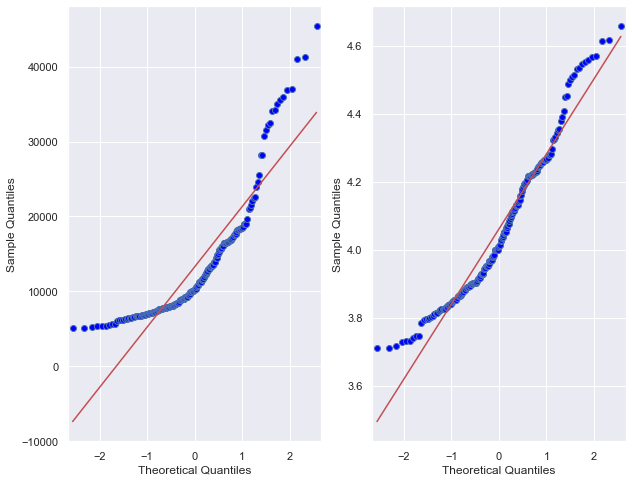

In [10]:
fig, axs = plt.subplots(ncols=2)
sm.qqplot(auto_price['price'], line='s', ax=axs[0])
sm.qqplot(auto_price['log_10_base_price'], line='s', ax=axs[1]);


Results: I accepted my null hypothesis that there is a statsitically significant difference between the price and log price



- For the rest of the assignment I will use the log_10_base_price due it having a more "normal distribution"

2. Test the significance of price broken up by a) fuel type, b) aspiration, and c) rear vs. front wheel drive. You are running separate tests for each variable. Use both graphical methods and the formal test. <span style="color:red" float:right>[5 point]</span>

Sources and Scratch

1. Wilcoxon 
2. Shapiro Tests
3. T-Test (paired t-test)
4. OLS

- https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
- https://songhuiming.github.io/pages/2017/01/21/linear-regression-in-python-chapter-3-regression-with-categorical-predictors/

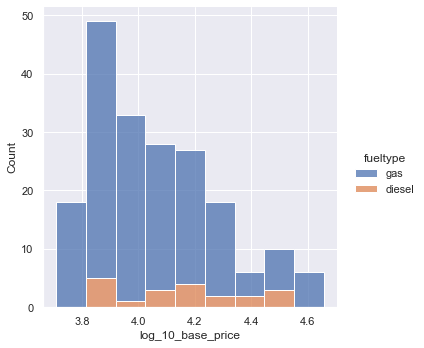

In [47]:
sns.displot(data=auto_price, x='log_10_base_price', hue='fueltype', multiple='stack');

Test being used: T-Test (paired)

- Hypothesis - There is no statistical difference in price for different fuel type
- Null Hypothesis - There is a statisical difference in price for different fuel types

In [48]:
auto_price['fueltype'].value_counts()

gas       175
diesel     20
Name: fueltype, dtype: int64

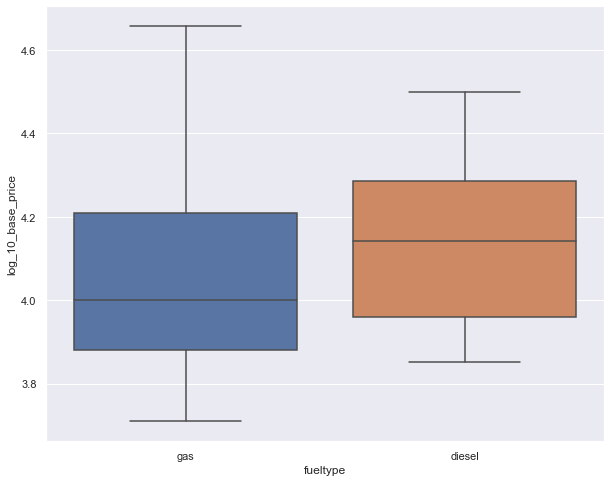

In [49]:
sns.boxplot(x='fueltype', y='log_10_base_price', data=auto_price);

With such a small sample size, will the test yield any kind of meaningful results?

In [50]:
fuel_gas = auto_price.query('fueltype=="gas"')['log_10_base_price']
fuel_diesel = auto_price.query('fueltype=="diesel"')['log_10_base_price']

In [51]:
ss.kstest(fuel_gas, 'norm') #Just to see how the data is distributed

KstestResult(statistic=0.9998960014791562, pvalue=0.0)

In [52]:
ss.kstest(fuel_diesel, 'norm')

KstestResult(statistic=0.9999412290942693, pvalue=4.8336774985031765e-85)

In [53]:
fuel_dif = ss.ttest_ind(fuel_gas, fuel_diesel, equal_var=False)
fuel_dif

Ttest_indResult(statistic=-2.001878864464547, pvalue=0.0567524747706863)

- I can reject my null hypothesis that there is a significant difference in price between diesel and gas cars

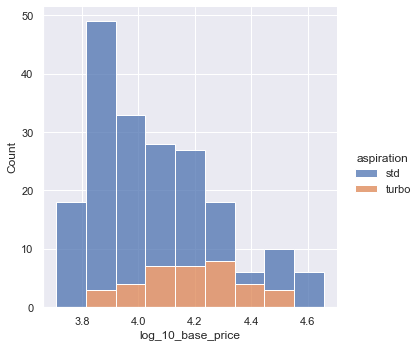

In [54]:
sns.displot(data=auto_price, x='log_10_base_price', hue='aspiration', multiple='stack');

Test being used: T-Test (paired)
- Hypothesis - There is no statistical difference between prices of cars with aspiration
- Null Hypothesis - There is a statistical difference between prices of cars with aspiration

In [55]:
auto_price['aspiration'].value_counts()

std      159
turbo     36
Name: aspiration, dtype: int64

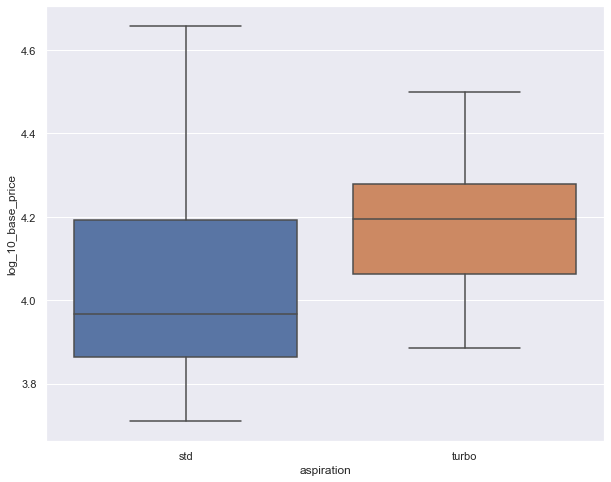

In [56]:
sns.boxplot(x='aspiration', y='log_10_base_price', data=auto_price);

In [57]:
std_asp = auto_price.query('aspiration=="std"')['log_10_base_price']
turbo_asp = auto_price.query('aspiration=="turbo"')['log_10_base_price']

In [58]:
ss.shapiro(std_asp)

ShapiroResult(statistic=0.9154965281486511, pvalue=5.4426180895461584e-08)

In [59]:
ss.shapiro(turbo_asp)

ShapiroResult(statistic=0.9727745056152344, pvalue=0.506051778793335)

In [60]:
aspiration_dif = ss.ttest_ind(std_asp, turbo_asp, equal_var=False)
aspiration_dif

Ttest_indResult(statistic=-4.472292180082559, pvalue=3.075306228142096e-05)

- Can accept my null hypothesis that there is a statistical difference between prices of cars with std or turbo

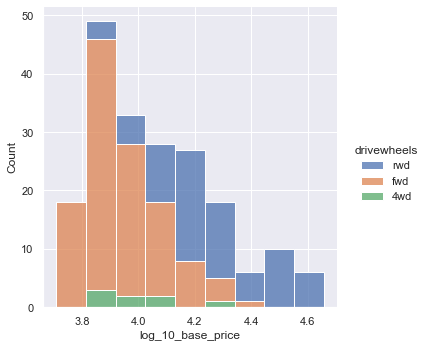

In [61]:
sns.displot(data=auto_price, x='log_10_base_price', hue='drivewheels', multiple='stack');

Test being used: T-Test (paired)
- Hypothesis - there is no statistical difference between rwd, fwd, and 4wd in price
- Null Hypothesis - there is a statistical difference between rwd, fwd, and 4wd in price

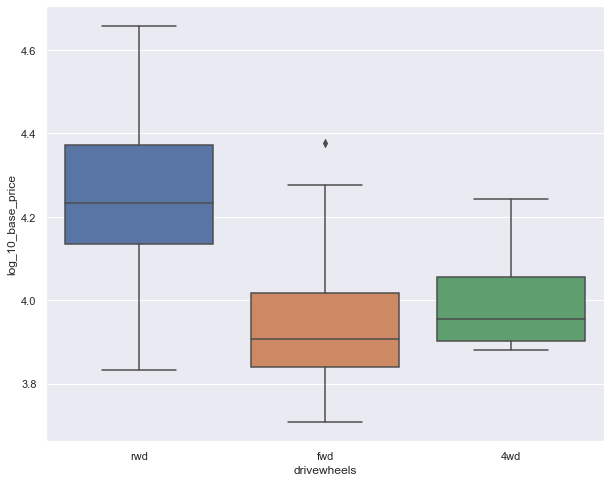

In [62]:
sns.boxplot(x='drivewheels', y='log_10_base_price', data=auto_price);

In [63]:
auto_price['drivewheels'].value_counts()

fwd    116
rwd     71
4wd      8
Name: drivewheels, dtype: int64

In [64]:
drive_fwd = auto_price.query('drivewheels=="fwd"')['price']
drive_rwd = auto_price.query('drivewheels=="rwd"')['price']

In [65]:
print(type(drive_fwd))
print(type(drive_rwd))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [66]:
print(drive_fwd.head())
print(drive_rwd.head())

3    13950
5    15250
6    17710
7    18920
8    23875
Name: price, dtype: int64
0     13495
1     16500
2     16500
10    16430
11    16925
Name: price, dtype: int64


In [67]:
drive_dif = ss.ttest_ind(drive_fwd, drive_rwd, equal_var=False)
drive_dif

Ttest_indResult(statistic=-9.613379714104708, pvalue=4.4949892928681865e-15)

- I can accept my null hypothesis that there is a statistical difference in price

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the price of autos for different body styles. Note that ANOVA and Tukey's HSD are **two separate tests**! <span style="color:red" float:right>[5 point]</span>

https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/

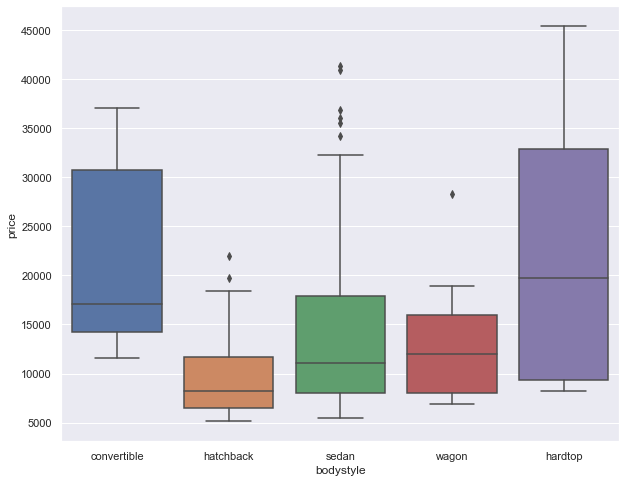

In [68]:
sns.boxplot(x='bodystyle', y='price', data=auto_price);

- Hypothesis: There is not a statistical difference between bodystyle's and price
- Null Hypothesis: There is a statistical difference between bodystyle's and price


Anova Test

In [69]:
model_price = ols('price ~ bodystyle', data = auto_price).fit()
anova_table = sm.stats.anova_lm(model_price)
print(anova_table)

              df        sum_sq       mean_sq        F    PR(>F)
bodystyle    4.0  2.006646e+09  5.016614e+08  9.00494  0.000001
Residual   190.0  1.058482e+10  5.570957e+07      NaN       NaN


In [70]:
model_log10 = ols('log_10_base_price ~ bodystyle', data = auto_price).fit()
anova_table_log = sm.stats.anova_lm(model_log10)
print(anova_table)

              df        sum_sq       mean_sq        F    PR(>F)
bodystyle    4.0  2.006646e+09  5.016614e+08  9.00494  0.000001
Residual   190.0  1.058482e+10  5.570957e+07      NaN       NaN


- ANOVA results signify that there is a statistical difference between certain groups of the bodystyle

In [71]:
tukey_price = pairwise_tukeyhsd(auto_price['price'],
                              auto_price['bodystyle'])
print(tukey_price)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1     group2    meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------
convertible   hardtop       318.0    0.9 -10784.1247 11420.1247  False
convertible hatchback -12126.5159 0.0018 -20909.4848 -3343.5469   True
convertible     sedan  -7430.7447 0.1295 -16086.8623   1225.373  False
convertible     wagon  -9390.3333 0.0497 -18773.3413    -7.3254   True
    hardtop hatchback -12444.5159  0.001 -20160.2385 -4728.7932   True
    hardtop     sedan  -7748.7447  0.042 -15319.7555  -177.7338   True
    hardtop     wagon  -9708.3333 0.0144 -18100.7508 -1315.9159   True
  hatchback     sedan   4695.7712 0.0014   1348.5969  8042.9455   True
  hatchback     wagon   2736.1825 0.5394  -2194.9472  7667.3123  False
      sedan     wagon  -1959.5887  0.754  -6661.0639  2741.8866  False
----------------------------------------------------------------------


In [72]:
tukey_log = pairwise_tukeyhsd(auto_price['log_10_base_price'],
                              auto_price['bodystyle'])
print(tukey_log)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------------
convertible   hardtop   -0.042    0.9 -0.3472  0.2632  False
convertible hatchback  -0.3411 0.0013 -0.5825 -0.0996   True
convertible     sedan  -0.1963 0.1588 -0.4342  0.0417  False
convertible     wagon  -0.2306 0.1037 -0.4886  0.0273  False
    hardtop hatchback  -0.2991 0.0013 -0.5112  -0.087   True
    hardtop     sedan  -0.1543 0.2502 -0.3624  0.0538  False
    hardtop     wagon  -0.1886 0.1655 -0.4194  0.0421  False
  hatchback     sedan   0.1448  0.001  0.0528  0.2368   True
  hatchback     wagon   0.1105 0.1682 -0.0251   0.246  False
      sedan     wagon  -0.0343    0.9 -0.1636  0.0949  False
------------------------------------------------------------


- I was able to accept my null hypthesis that there was statistical correlation with the different body types

4. Graphically explore the differences in price between the cars of different body styles. If any of these relationships are statistically significant (as suggested by Tukey's HSD), examine the sample size and decide if they should be considered practically significant. <span style="color:red" float:right>[5 point]</span>

Scratch and Notes
- https://seaborn.pydata.org/generated/seaborn.violinplot.html
- https://chartio.com/learn/charts/violin-plot-complete-guide/
- https://seaborn.pydata.org/generated/seaborn.stripplot.html
- https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot


Would like to first see the distribution of the data in terms of counts

In [73]:
auto_price['bodystyle'].value_counts()

sedan          94
hatchback      63
wagon          24
hardtop         8
convertible     6
Name: bodystyle, dtype: int64

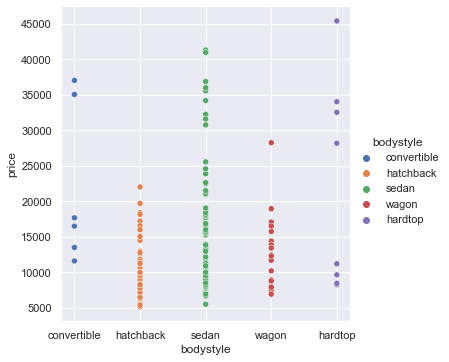

In [74]:
sns.relplot(x='bodystyle', y='price', hue='bodystyle', data=auto_price)

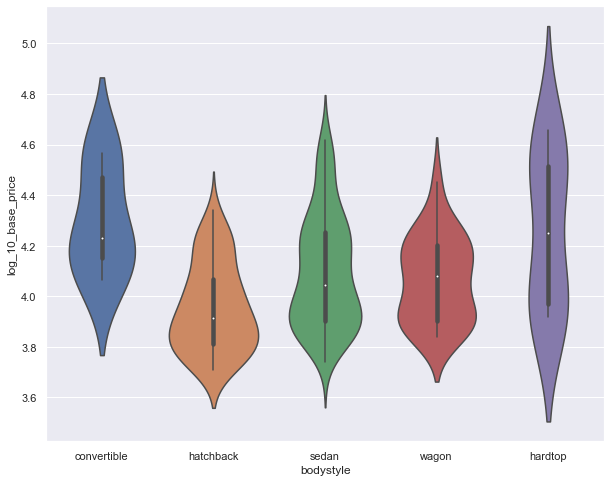

In [75]:
sns.violinplot(x="bodystyle", y="log_10_base_price", data=auto_price);

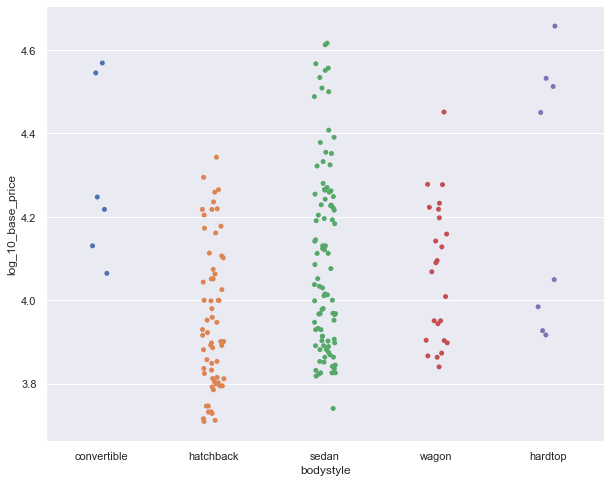

In [76]:
sns.stripplot(x="bodystyle", y="log_10_base_price", data=auto_price, jitter=True);

In [77]:
auto_price.head()

,symboling,make,fueltype,aspiration,num-of-doors,bodystyle,drivewheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,log_10_base_price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495,4.130173
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500,4.217484
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500,4.217484
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950,4.144574
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450,4.241795


In [41]:
auto_price[['price', 'make', 'num-of-doors','horsepower']].corr()

,price,horsepower
price,1.000000,0.811027
horsepower,0.811027,1.000000


In [78]:
#Break out by prices potentially

In [81]:
auto_price.plot(x=[body_style=['convertible', 'hatchback']], y='price', kind='line')

SyntaxError: invalid syntax (<ipython-input-81-6dc479e842d7>, line 1)

Statistically Significant:
- Convertable to Hatchback, Sedan, and Wagon
- Hardtop to Hatchback, Segan, Wagon
- Hatchback to Sedan

   
Note that to get full grade, for graphical tests you should include commentary on what your plot is showing. For formal tests should include the following:
- begin by naming the test you are using
- begin by clearly stating the null and alternative hypotheses
- run the test and report the statistic and p-value
- based on the p-value you should state the conclusion

# End of assignment